### Regime Identification in Multivariate Time-series

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import regimes
import numpy as np
import pandas as pd
import seaborn as sns
from clasp import ClaSP
from scipy import stats
from spdms import getSPDMs
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

np.random.seed(1)

In [3]:
# Normalization (Standard)
def normalize(data, type='minmax'):

    if type=='std':
        return (np.array(data) - np.mean(data))/np.std(data)
        
    elif type=='minmax':
        return (np.array(data) - np.min(data))/(np.max(data) - np.min(data))

In [4]:
# Read real data (tectonic-climate time series)
# data = pd.read_csv(r'../datasets/moxa_data_D.csv')

# Read synthetically generated time series
data = pd.read_csv(r'../datasets/synthetic_datac.csv')

In [5]:
# rdata = reduce_dimension(spdms, 2)
# spdms = np.take(rdata, 0, axis=3)
# print(spdms.shape)
# rdata[:, :, :, 0].shape

In [6]:
# np.transpose(rdata[:, :, :, 0]).shape

In [7]:
# start, end = '2014-11-01', '2016-12-30'

# Appy mask get a segment from time series
# mask = (data['DateTime'] > '2014-11-01') & (data['DateTime'] <= '2015-12-28')
# data = data.loc[mask]

# data = data.fillna(method='pad')
# data = data.set_index('DateTime')
# data = data[start: end]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 1099
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Z1      1100 non-null   float64
 1   Z2      1100 non-null   float64
 2   Z3      1100 non-null   float64
 3   Z4      1100 non-null   float64
 4   Z5      1100 non-null   float64
dtypes: float64(5)
memory usage: 51.6 KB


In [8]:
data.isnull().sum()

Z1    0
Z2    0
Z3    0
Z4    0
Z5    0
dtype: int64

In [9]:
data = data.apply(normalize)

In [10]:
data.isnull().sum()

Z1    0
Z2    0
Z3    0
Z4    0
Z5    0
dtype: int64

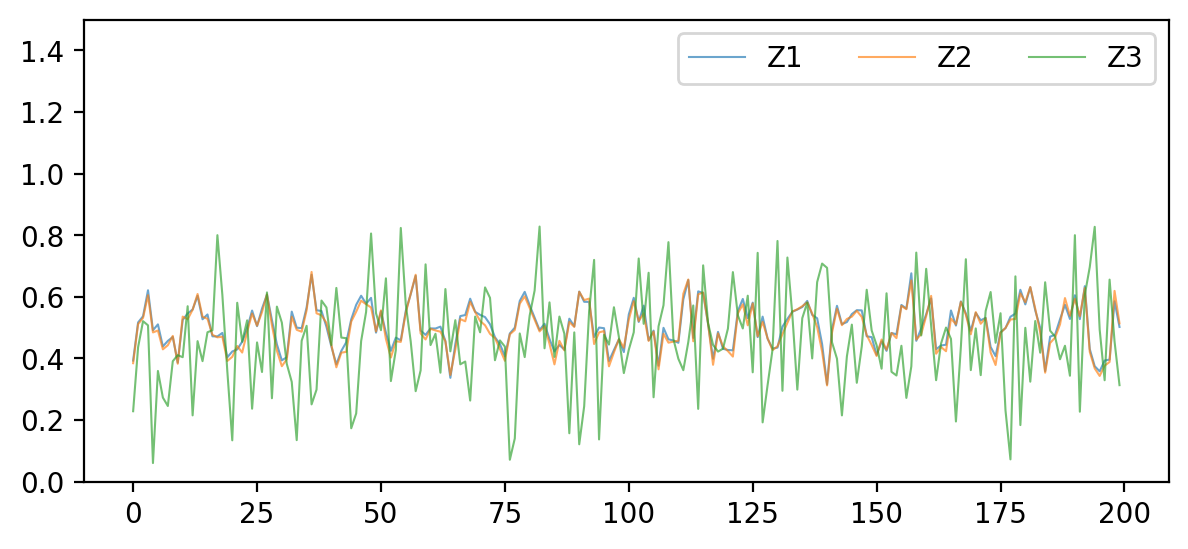

In [11]:
# toplot = [ 'rain', 'snow_load', 'pressure_outside','gw_mb', 'gw_sg', 'gw_west', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'temperature_outside', 'strain_ew_corrected', 'strain_ns_corrected']
toplot = ['Z1', 'Z2','Z3']

for i in toplot:
    data[i][:200].plot(use_index=True, figsize=(7, 3), linewidth=0.75, alpha=0.66)
    plt.legend(toplot, frameon=True, ncol=3)


plt.ylim(0, 1.5)
# plt.gcf().autofmt_xdate()
# plt.legend(['Temperature', 'Ground Water', 'Strain_EW', 'Strain_NS'])
# plt.legend(['$Z_{1}$', '$Z_{2}$', '$Z_{3}$'])
# plt.savefig("synreg25Apr.png")
plt.show()

In [12]:
# Desired number of clusters
k = 3

# Sliding window size
winsize = 50 # 155

# distance metrics
metricE = 'Euclidean'
metricR = 'Riemannian'

dim = '2' 
# dim=n where n is dimesion size i.e. 2, 3, 4...., rather than using full dimension dim='full' 

clusters, cluster_idx, *_ = regimes.get_regimes(data, winsize, k, metricR, dim)

# Start optimization using solver: trustregion
Optimizing...
                                            f: -3.344777e-02   |grad|: 4.454652e-02
acc TR+   k:     1     num_inner:     0     f: -4.045983e-02   |grad|: 3.419253e-02   exceeded trust region
acc TR+   k:     2     num_inner:     0     f: -4.589424e-02   |grad|: 1.099845e-02   exceeded trust region
acc       k:     3     num_inner:     1     f: -5.071591e-02   |grad|: 2.021610e-02   negative curvature
acc       k:     4     num_inner:     1     f: -5.409382e-02   |grad|: 1.215233e-02   exceeded trust region
acc       k:     5     num_inner:     1     f: -5.855843e-02   |grad|: 2.214504e-02   exceeded trust region
acc       k:     6     num_inner:     1     f: -6.401323e-02   |grad|: 4.310047e-02   negative curvature
acc       k:     7     num_inner:     1     f: -7.357490e-02   |grad|: 2.167012e-02   exceeded trust region
acc       k:     8     num_inner:     2     f: -7.521961e-02   |grad|: 9.162768e-04   reached target resi

In [13]:
clusters_extended = []

for i in range(len(clusters)):

    val = clusters[i]
    for j in range(winsize):
        clusters_extended.append(val)
        
print(len(clusters_extended), data.shape)

1050 (1100, 5)


In [14]:
datanew = data.iloc[:len(clusters_extended), :].copy()
datanew['Clusters'] = clusters_extended

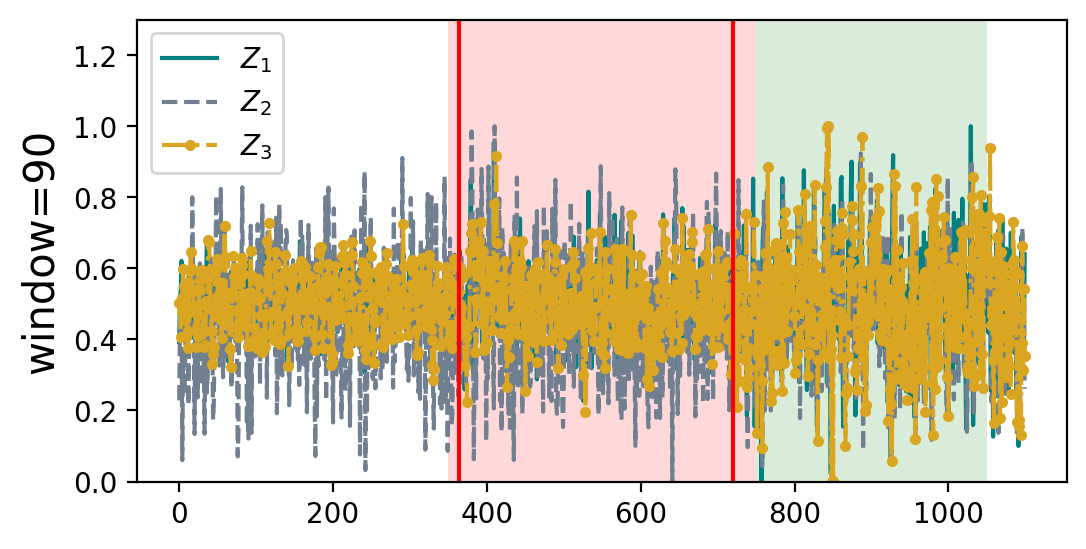

In [15]:
regimes.plot_regimes(data, clusters, cluster_idx, winsize, dtype='synthetic')